In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
from torch.utils.data import default_collate
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from torchmetrics import SpearmanCorrCoef

In [2]:
def get_image_data(method: str, net_out: str, task: str, scanner: int):
    directory = f'../../results-tmp/results/eval/{net_out}/image/'
    image_data = []
    for file in os.listdir(directory):
        if method in file and 'ood' in file and scanner in file[:-2] and 'auroc' in file:
            f = torch.load(directory + file)
            image_data.append(f) 
    return default_collate(image_data)

In [3]:
df_ood_mms = pd.DataFrame(columns=['method', 'Domain', 'run', 'AUROC'])
for method in ['gonzales', 'latents', 'entropy', 'ensemble_tmp', 'ae']:
    for scanner in ['val', 'A', 'B', 'C','D']:
        
        if 'ensemble' in method:
            task = 'ood'
        else:
            task = 'both'
        try:
            tmp = get_image_data(method=method, 
                                 net_out='mms', 
                                 task=task, 
                                 scanner=str(scanner))

            if scanner == 'A':
                domain = 'Siemens \n(M&M)'
            if scanner == 'B':
                domain = 'Philips'
            if scanner == 'C':
                domain = 'GE'
            if scanner == 'D':
                domain = 'Canon'
            if scanner == 'val':
                continue

            if method == 'gonzales':
                m = 'Pooling Mahalanobis'
            if method == 'entropy':
                m = 'Entropy - Single Net'
            if method == 'latents':
                m = 'Latent Mahalanobis'
            if method == 'ae':
                m = 'Segmentation Distortion'
            if method == 'ensemble_tmp':
                m = 'Entropy - Ensemble'

            for i, ood in enumerate(tmp['ood']):
                row = {'Domain': domain, 
                       'method': m, 
                       'run': i, 
                       'AUROC': ood.numpy().item()}

                df_ood_mms = df_ood_mms.append(row, ignore_index=True)
        except:
            print(f"\nPassed {method}{scanner}\n")


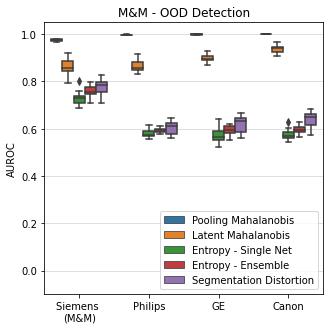

In [11]:
fig, axes = plt.subplots(1, 1, figsize=(5,5),  gridspec_kw={'hspace': 0})
axes.set_title('M&M - OOD Detection')

sns.boxplot(ax=axes, x="Domain", y="AUROC",
        hue="method", data=df_ood_mms)
axes.legend().set_title('')
axes.set_xlabel("")
axes.set_ylim(-0.1, 1.05)
axes.set_axisbelow(True)
axes.yaxis.grid(True, alpha=0.5, zorder=0)
fig.savefig("../../results-tmp/results/eval/mms_ood.png", bbox_inches='tight', dpi=400, transparent=True)

In [5]:
heart = np.load('../../results-tmp/results/unet/heart_unet_results.npy', allow_pickle=True).item()

In [6]:
df = pd.DataFrame(columns = ['DCS', 'Domain'])
for key in heart:
    
    if 'acdc_train' in key:
        continue
    if 'acdc_val' in key:
        domain = 'Siemens \n(val)'
    
    if 'siemens' in key:
        domain = 'Siemens'
    if 'philips' in key:
        domain = 'Philips'
    if 'canon' in key:
        domain = 'Canon'
    if 'ge' in key:
        domain = 'GE'
    
    values = np.array([heart[key], [domain]*10]).T
    for value in values:
        row = {'DCS': value[0],
               'Domain': value[1]}
        #print(row)
        df = df.append(row, ignore_index=True)
    #df.append([heart[key], [key]*10], ignore_index=True)

In [7]:
df['DCS'] = df['DCS'].astype(float)

In [8]:
df = pd.read_csv("../../results-tmp/results/eval/mms_dcs.pd")
df['Vendor'] = df['Vendor'].replace("M&M - Philips", "Philips")
df['Vendor'] = df['Vendor'].replace("M&M - GE", "GE")
df['Vendor'] = df['Vendor'].replace("M&M - Siemens", "Siemens \n(M&M)")
df['Vendor'] = df['Vendor'].replace("M&M - Canon", "Canon")
df['Vendor'] = df['Vendor'].replace("ACDC - Siemens (val)", "Siemens \n(ACDC)")

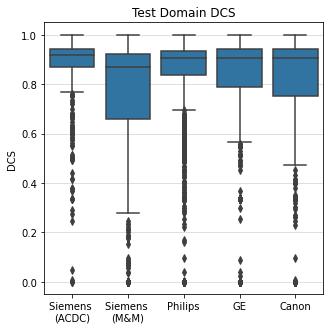

In [10]:
fig, axes = plt.subplots(1, 1, figsize=(5,5),  gridspec_kw={'hspace': 0})

sns.boxplot(ax=axes, x="Vendor", y="DCS", data=df, color='tab:blue')
axes.set_title("Test Domain DCS")
axes.set_xlabel("")
axes.set_axisbelow(True)
axes.yaxis.grid(True, alpha=0.5, zorder=0)
#axes.set_ylim(0.6, 0.9)
fig.savefig("../../results-tmp/results/unet/mms_dcs.png", bbox_inches='tight', dpi=400, transparent=True)